# LGBM을 활용한 베이스라인

In [300]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [301]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [302]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['hour'] = df['Timestamp'].dt.hour
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    df['elapsed'] = diff
    
    df['Bigcat'] = df['testId'].str[2]
    df['Bigcat'] = df['Bigcat'].astype('category')
    
    df['smallcat'] = df['testId'].str[7:10]
    df['smallcat'] = df['smallcat'].astype('category')
    sc2idx = {v:k for k,v in enumerate(df['smallcat'].unique())}
    df['smallcat'] = df['smallcat'].map(sc2idx)
    
    ## 문제 번호 추가
    df['item_num'] = df['assessmentItemID'].str[7:]
    df['item_num'] = df['item_num'].astype('category')
    # in2idx = {v:k for k,v in enumerate(df['item_num'].unique())}
    # df['item_num'] = df['item_num'].map(in2idx)
    
    ## 같은 문제 몇번째 푸는지
    df['same_item_cnt'] = df.groupby(['userID', 'assessmentItemID']).cumcount() + 1
    
    ## 문제 푼 순서 추가 > 상대적 순서?
    df['item_seq'] = df.groupby(['userID', 'testId', 'same_item_cnt']).cumcount() +1
    df['item_seq'] = df['item_seq'] - df['item_num'].astype(int)
    
    df['item_num'] = df['item_num'].astype('category')
    df['item_seq'] = df['item_seq'].astype('category')
    # is2idx = {v:k for k,v in enumerate(df['item_seq'].unique())}
    # df['item_seq'] = df['item_seq'].map(is2idx)
    
    ## 문제 푼 시간 재정의
    # 유저, test, same_item_cnt 구분했을 때 문제 푸는데 걸린 시간 > shift, fillna x
    diff_shift = df.loc[:, ['userID', 'testId', 'Timestamp', 'same_item_cnt']].groupby(['userID', 'testId', 'same_item_cnt']).diff().shift(-1)
    diff_shift = diff_shift['Timestamp'].apply(lambda x: x.total_seconds())
    df['solved_time_shift'] = diff_shift
    df['solved_time_shift'] = df.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time_shift'].apply(lambda x:x.fillna(x.mean()))
    

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [303]:
df = feature_engineering(df)
df.head()

/tmp/ipykernel_95414/2472296618.py:48: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['solved_time_shift'] = df.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time_shift'].apply(lambda x:x.fillna(x.mean()))


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,hour,...,Bigcat,smallcat,item_num,same_item_cnt,item_seq,solved_time_shift,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0,...,6,0,001,1,0,3.0,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0,...,6,0,002,1,0,8.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0,...,6,0,003,1,0,7.0,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0,...,6,0,004,1,0,7.0,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0,...,6,0,005,1,0,11.0,0.947683,1268,0.913187,3040


## 3. Train/Test 데이터 셋 분리

In [304]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [305]:
# train

In [306]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed','Bigcat','smallcat']
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed', 'Bigcat', 'smallcat', 'item_num', 'item_seq', 'solved_time_shift']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [307]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [308]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [309]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,hour,...,Bigcat,smallcat,item_num,same_item_cnt,item_seq,solved_time_shift,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0,...,6,0,001,1,0,3.000000,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.000000,0,...,6,0,002,1,0,8.000000,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.000000,0,...,6,0,003,1,0,7.000000,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.000000,0,...,6,0,004,1,0,7.000000,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.000000,0,...,6,0,005,1,0,11.000000,0.947683,1268,0.913187,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1.0,4,0.250000,6,...,3,157,005,1,0,55.000000,0.662590,921,0.689706,2814
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1.0,5,0.200000,1,...,4,124,001,1,0,11.000000,0.655109,718,0.697874,2199
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2.0,6,0.333333,1,...,4,124,002,1,0,46.000000,0.655109,718,0.697874,2199
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3.0,7,0.428571,1,...,4,124,003,1,0,73.000000,0.655109,718,0.697874,2199


In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266586 entries, 0 to 2266585
Data columns (total 21 columns):
 #   Column               Dtype         
---  ------               -----         
 0   userID               int64         
 1   assessmentItemID     object        
 2   testId               object        
 3   answerCode           int64         
 4   Timestamp            datetime64[ns]
 5   KnowledgeTag         int64         
 6   user_correct_answer  float64       
 7   user_total_answer    int64         
 8   user_acc             float64       
 9   hour                 int64         
 10  elapsed              float64       
 11  Bigcat               category      
 12  smallcat             category      
 13  item_num             category      
 14  same_item_cnt        int64         
 15  item_seq             category      
 16  solved_time_shift    float64       
 17  test_mean            float64       
 18  test_sum             int64         
 19  tag_mean             

## 4. 훈련 및 검증

In [320]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.483021	valid_1's binary_logloss: 0.563833
[200]	training's binary_logloss: 0.47359	valid_1's binary_logloss: 0.556892
[300]	training's binary_logloss: 0.467464	valid_1's binary_logloss: 0.552857
[400]	training's binary_logloss: 0.462831	valid_1's binary_logloss: 0.549949
[500]	training's binary_logloss: 0.459352	valid_1's binary_logloss:

In [312]:
# INSTALL MATPLOTLIB IN ADVANCE
# _ = lgb.plot_importance(model)

## 5. Inference

In [324]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

744


/tmp/ipykernel_95414/2472296618.py:48: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['solved_time_shift'] = df.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time_shift'].apply(lambda x:x.fillna(x.mean()))


In [322]:
test_df.head(10)

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,hour,elapsed,Bigcat,smallcat,item_num,same_item_cnt,item_seq,solved_time_shift,test_mean,test_sum,tag_mean,tag_sum
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,717.0,1035,0.692754,13,46.0,5,105,008,1,0,45.142857,0.661765,90,0.542662,159
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,465.0,670,0.694030,2,23.0,7,136,008,1,0,24.571429,0.740385,77,0.565693,155
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,915.0,1316,0.695289,4,8.0,7,90,008,1,0,14.857143,0.417857,117,0.446753,172
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,1031.0,1259,0.818904,5,75.0,9,109,006,1,0,76.000000,0.625000,30,0.514286,36
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,293.0,386,0.759067,11,17.0,6,98,007,1,0,45.833333,0.678571,133,0.602767,305
5524,29,A020190005,A020000190,2020-10-22 04:38:45,8097,723.0,853,0.847597,4,30.0,2,182,005,1,0,26.000000,0.683333,41,0.642424,106
6608,45,A040136005,A040000136,2020-10-23 08:24:19,2107,746.0,1083,0.688827,8,4.0,4,99,005,1,0,25.000000,0.562963,76,0.647059,352
7301,53,A040140005,A040000140,2020-10-26 09:13:20,2110,362.0,692,0.523121,9,20.0,4,133,005,1,0,10.250000,0.600000,102,0.665049,274
8112,58,A070159007,A070000159,2020-12-24 21:09:29,9122,295.0,810,0.364198,21,2.0,7,160,007,1,1,1.857143,0.510714,143,0.343478,79
9382,64,A070146008,A070000146,2020-12-29 04:30:22,9080,1058.0,1269,0.833727,4,2.0,7,136,008,1,0,1.714286,0.740385,77,0.565693,155


In [314]:
test_df['assessmentItemID'].str[7:].unique()

array(['008', '006', '007', '005', '004', '009', '012', '003', '010',
       '013', '011', '002', '001'], dtype=object)

In [315]:
test_df

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,hour,elapsed,Bigcat,smallcat,item_num,same_item_cnt,item_seq,solved_time_shift,test_mean,test_sum,tag_mean,tag_sum
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,717.0,1035,0.692754,13,46.0,5,105,008,1,0,45.142857,0.661765,90,0.542662,159
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,465.0,670,0.694030,2,23.0,7,136,008,1,0,24.571429,0.740385,77,0.565693,155
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,915.0,1316,0.695289,4,8.0,7,90,008,1,0,14.857143,0.417857,117,0.446753,172
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,1031.0,1259,0.818904,5,75.0,9,109,006,1,0,76.000000,0.625000,30,0.514286,36
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,293.0,386,0.759067,11,17.0,6,98,007,1,0,45.833333,0.678571,133,0.602767,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,2020-09-08 02:05:20,10615,7.0,23,0.304348,2,2.0,4,120,005,1,0,3.000000,0.753846,147,0.654902,167
260067,7404,A030111005,A030000111,2020-10-13 09:49:18,7636,7.0,14,0.500000,9,107.0,3,90,005,1,0,54.750000,0.866667,156,0.834661,419
260082,7416,A050193004,A050000193,2020-10-04 02:44:41,10402,7.0,14,0.500000,2,24.0,5,175,004,1,0,15.666667,0.750000,75,0.792517,233
260097,7417,A050193004,A050000193,2020-09-06 13:09:15,10402,2.0,14,0.142857,13,21.0,5,175,004,1,0,21.000000,0.750000,75,0.792517,233


In [316]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [317]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "lgbm_cet_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/lgbm_cet_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.



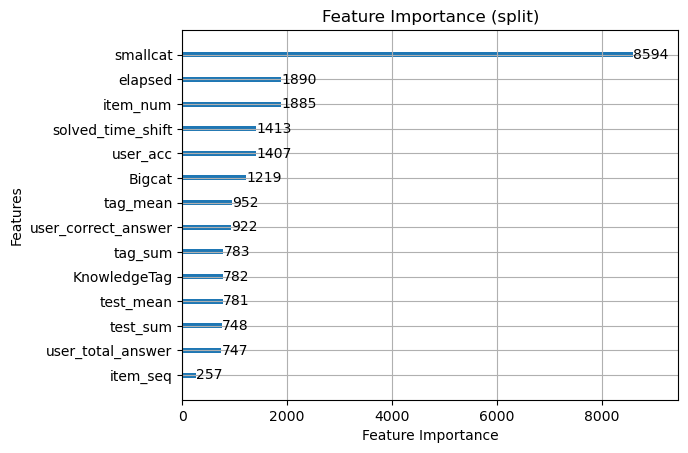

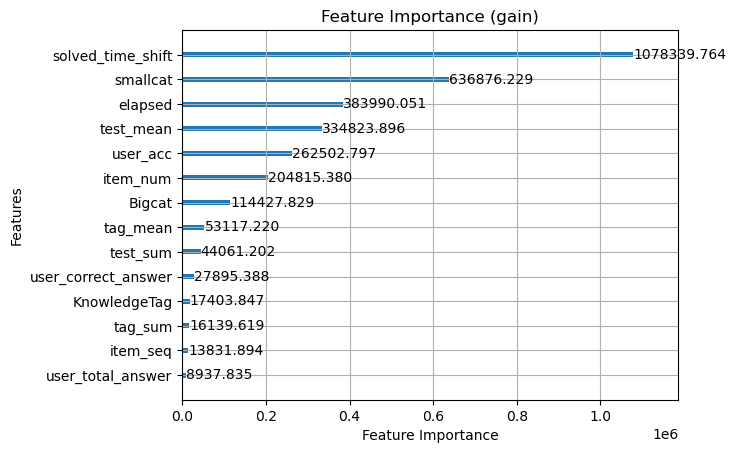

In [318]:
# model: 이미 학습이 완료된 LGBMModel, or Booster
# FEATURES: model 학습에 사용된 모든 features
# PATH: 그림을 저장할 경로

# SPLIT
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_split.png', dpi=300)


# GAIN
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_gain.png', dpi=300)